In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append("..")

from src.pickle_manager import open_parquet
from src.evaluation import plot_confusion_matrix

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def get_date(reg_date: pd.Timestamp, ogrn: int, msp_date: pd.Timestamp) -> pd.Timestamp:
    """Apply reg_date using year calculated from ogrn"""
    if pd.isnull(reg_date) and msp_date == datetime.datetime(2016, 8, 1):
        reg_date = datetime.datetime(int("20" + str(ogrn)[1:3]), 8, 10)
    elif pd.isnull(reg_date) and msp_date != datetime.datetime(2016, 8, 1):
        reg_date = msp_date
    return reg_date

In [3]:
def classify_lifetime(lifetime):
    """Classify lifetime into categories."""
    if lifetime <= 24:
        return 0
    elif 24 < lifetime <= 120:
        return 1
    elif lifetime > 120:
        return 2

In [4]:
def inverse_classify_lifetime(category: int):
    """Return the range of lifetimes for a given category."""
    if category == 0:
        return 24
    elif category == 1:
        return 120
    elif category == 2:
        return float('inf')
    else:
        return None

In [5]:
init_data = open_parquet("../data/parquet", "companies_feat_open.parquet")
predictions = open_parquet("../results", "predicts_2023-11-28_08-08-38.parquet")

In [6]:
tqdm.pandas()
init_data["reg_date"] = init_data.progress_apply(
    lambda row: get_date(row["reg_date"], row["ОГРН"], row["Дата включения в реестр"]),
    axis=1,
)

100%|██████████| 5748961/5748961 [01:51<00:00, 51331.89it/s] 


In [7]:
init_data["current_lifetime"] = (
    datetime.now().year - init_data["reg_date"].dt.year
) * 12 + (datetime.now().month - init_data["reg_date"].dt.month)

In [8]:
max_trained_llifetime = (datetime.now().year - 2000) * 12 + datetime.now().month - 1

In [9]:
init_data = init_data[init_data["current_lifetime"] < max_trained_llifetime]

In [10]:
init_data = init_data[["ОГРН", "current_lifetime"]]

In [11]:
predictions = pd.merge(
    left=init_data, right=predictions, how="inner", left_on="ОГРН", right_on="OGRN"
)

In [12]:
predictions.drop(columns=["ОГРН"], inplace=True, errors="ignore")
predictions.head()

,current_lifetime,OGRN,Predicted Class,Probabilities
0,8,1233400001570,0,"0.99, 0.01, 0.00"
1,8,1236900001084,0,"0.98, 0.02, 0.00"
2,8,1237700112792,0,"0.93, 0.07, 0.00"
3,8,1232800000850,0,"0.96, 0.04, 0.00"
4,8,1236900001062,0,"0.99, 0.01, 0.00"


In [13]:
predictions["current_lifetime_classes"] = predictions["current_lifetime"].apply(
    classify_lifetime
)
predictions["predicted_lifetime_min"] = predictions["Predicted Class"].apply(
    inverse_classify_lifetime
)

In [14]:
y_hat_classes = predictions["Predicted Class"]
y_classes  = predictions["current_lifetime_classes"]
y_hat = predictions["predicted_lifetime_min"]
y  = predictions["current_lifetime"]

In [15]:
# Apply binary classification
mask_greater = y_hat >= y
mask_lesser = y_hat < y

y_hat[mask_greater] = 1
y[mask_greater] = 1

y_hat[mask_lesser] = 0
y[mask_lesser] = 1

/tmp/ipykernel_3356158/1866587962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_hat[mask_greater] = 1
/tmp/ipykernel_3356158/1866587962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[mask_greater] = 1
/tmp/ipykernel_3356158/1866587962.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_hat[mask_lesser] = 0
/tmp/ipykernel_3356158/1866587962.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

              precision    recall  f1-score   support

           0       0.40      0.95      0.57   1300910
           1       0.61      0.33      0.43   2822580
           2       0.91      0.63      0.74   1623941

    accuracy                           0.55   5747431
   macro avg       0.64      0.64      0.58   5747431
weighted avg       0.64      0.55      0.55   5747431



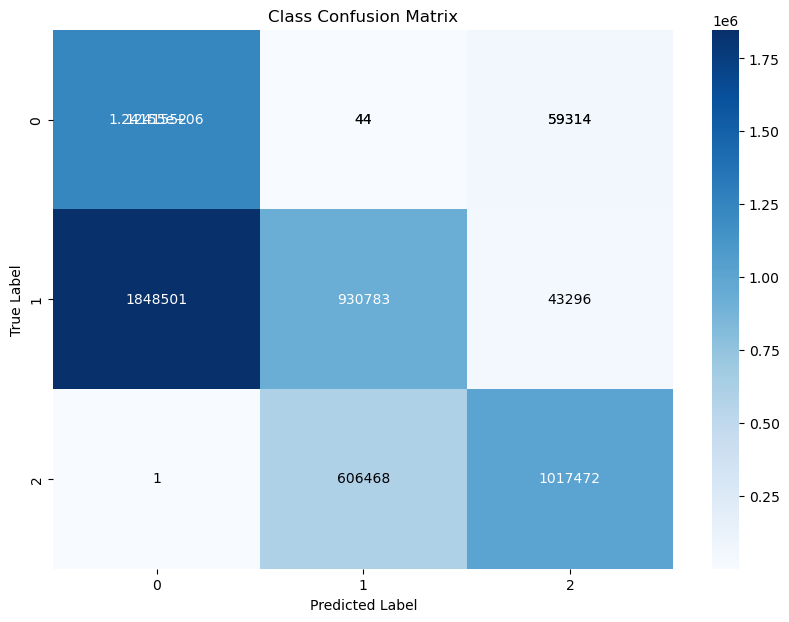

In [18]:
print(classification_report(y_classes, y_hat_classes))

class_conf_mat = confusion_matrix(y_classes, y_hat_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(class_conf_mat, annot=True, fmt='g', cmap='Blues')
plt.title("Class Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


ax = plt.gca()  
for i in range(class_conf_mat.shape[0]):
    for j in range(class_conf_mat.shape[1]):
        text = format(class_conf_mat[i, j], 'd')
        ax.text(j+0.5, i+0.5, text, ha="center", va="center", 
                color="white" if class_conf_mat[i, j] > class_conf_mat.max() / 2 else "black")

plt.show()

/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/stat_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.73   5747431

    accuracy                           0.57   5747431
   macro avg       0.50      0.29      0.36   5747431
weighted avg       1.00      0.57      0.73   5747431



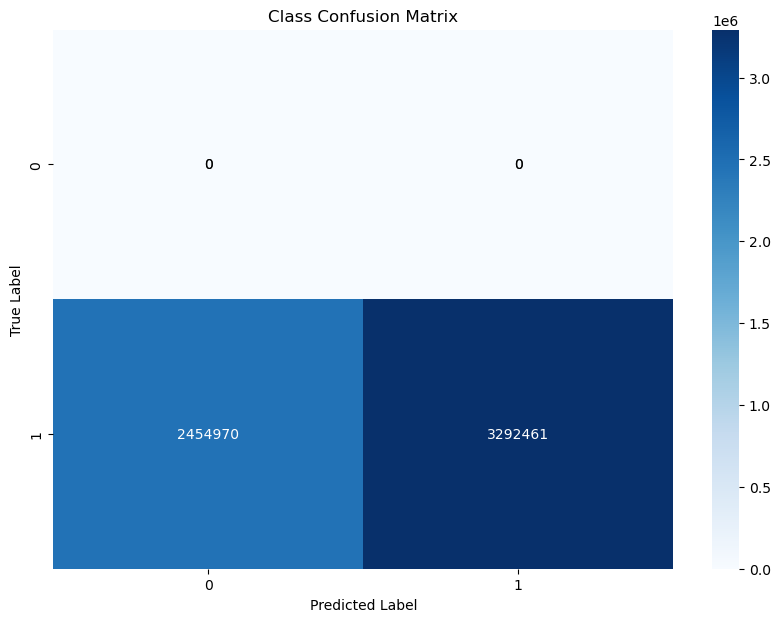

In [17]:
print(classification_report(y, y_hat))

binary_conf_mat  = confusion_matrix(y, y_hat)


plt.figure(figsize=(10, 7))
sns.heatmap(binary_conf_mat , annot=True, fmt='g', cmap='Blues')
plt.title("Class Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


ax = plt.gca()  
for i in range(binary_conf_mat.shape[0]):
    for j in range(binary_conf_mat.shape[1]):
        text = format(binary_conf_mat [i, j], 'd')
        ax.text(j+0.5, i+0.5, text, ha="center", va="center", 
                color="white" if binary_conf_mat [i, j] > binary_conf_mat .max() / 2 else "black")

plt.show()